# 0. Importing data to Colab

In [1]:
import os
import urllib.request
from zipfile import ZipFile

import h5py
import numpy as np
import scipy.io
from tqdm import tqdm
import numpy as np

# see: http://rgbd.cs.princeton.edu/ in section Data and Annotation
DATASET_URL = 'http://rgbd.cs.princeton.edu/data/SUNRGBD.zip'
DATASET_TOOLBOX_URL = 'http://rgbd.cs.princeton.edu/data/SUNRGBDtoolbox.zip'


class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_file(url, output_filepath, display_progressbar=False):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1],
                             disable=not display_progressbar) as t:
        urllib.request.urlretrieve(url,
                                   filename=output_filepath,
                                   reporthook=t.update_to)


In [2]:
output_path = os.getcwd()

os.makedirs(output_path, exist_ok=True)

toolbox_dir = os.path.join(output_path, 'SUNRGBDtoolbox')

# download and extract data
if not os.path.exists(toolbox_dir):
    zip_file_path = os.path.join(output_path, 'SUNRGBDtoolbox.zip')
    download_file(DATASET_TOOLBOX_URL, zip_file_path,
                    display_progressbar=True)
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(zip_file_path))
    os.remove(zip_file_path)

SUNRGBDtoolbox.zip: 570MB [00:13, 41.6MB/s]                           


In [3]:
zip_file_path = os.path.join(output_path, 'SUNRGBD.zip')
if not os.path.exists(zip_file_path):
    download_file(DATASET_URL, zip_file_path,
                    display_progressbar=True)
print('Extract images')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(zip_file_path))
os.remove(zip_file_path)

SUNRGBD.zip: 6.89GB [02:44, 41.8MB/s]                            


Extract images


In [4]:
# extract labels from SUNRGBD toolbox
print('Extract labels from SUNRGBD toolbox')
SUNRGBDMeta_dir = os.path.join(toolbox_dir, 'Metadata/SUNRGBDMeta.mat')
allsplit_dir = os.path.join(toolbox_dir, 'traintestSUNRGBD/allsplit.mat')
SUNRGBD2Dseg_dir = os.path.join(toolbox_dir, 'Metadata/SUNRGBD2Dseg.mat')
img_dir = []
depth_dir = []
label_dir = []

SUNRGBD2Dseg = h5py.File(SUNRGBD2Dseg_dir, mode='r', libver='latest')

# load the data from the matlab file
SUNRGBDMeta = scipy.io.loadmat(SUNRGBDMeta_dir, squeeze_me=True,
                                struct_as_record=False)['SUNRGBDMeta']
split = scipy.io.loadmat(allsplit_dir, squeeze_me=True,
                            struct_as_record=False)
split_train = split['alltrain']

seglabel = SUNRGBD2Dseg['SUNRGBD2Dseg']['seglabel']

for i, meta in tqdm(enumerate(SUNRGBDMeta)):
    meta_dir = '/'.join(meta.rgbpath.split('/')[:-2])
    real_dir = meta_dir.split('/n/fs/sun3d/data/SUNRGBD/')[1]
    depth_bfx_path = os.path.join(real_dir, 'depth_bfx/' + meta.depthname)
    rgb_path = os.path.join(real_dir, 'image/' + meta.rgbname)

    label_path = os.path.join(real_dir, 'label/label.npy')
    label_path_full = os.path.join(output_path, 'SUNRGBD', label_path)

    # save segmentation (label_path) as numpy array
    if not os.path.exists(label_path_full):
        os.makedirs(os.path.dirname(label_path_full), exist_ok=True)
        label = np.array(
            SUNRGBD2Dseg[seglabel[i][0]][:].transpose(1, 0)).\
            astype(np.uint8)
        np.save(label_path_full, label)

    if meta_dir in split_train:
        img_dir.append(os.path.join('SUNRGBD', rgb_path))
        depth_dir.append(os.path.join('SUNRGBD', depth_bfx_path))
        label_dir.append(os.path.join('SUNRGBD', label_path))
    else:
        img_dir.append(os.path.join('SUNRGBD', rgb_path))
        depth_dir.append(os.path.join('SUNRGBD', depth_bfx_path))
        label_dir.append(os.path.join('SUNRGBD', label_path))

# write file lists
def _write_list_to_file(list_, filepath):
    with open(os.path.join(output_path, filepath), 'w') as f:
        f.write('\n'.join(list_))
    print('written file {}'.format(filepath))

img_dir = [path.replace('\\', '/') for path in img_dir]
depth_dir = [path.replace('\\', '/') for path in depth_dir]
json_paths = [path.replace('\\', '/') for path in label_dir]

np.save('dataset_paths.npy', [img_dir, depth_dir, label_dir])

Extract labels from SUNRGBD toolbox


10335it [01:03, 163.98it/s]


# 2. ConvNeXt V2 - Pretrained

## 2.1. Model Setup

In [30]:
import torch
import albumentations as A
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import cv2

from utils_cov import (
    load_checkpoint,
    save_checkpoint,
    get_loaders,
    check_accuracy,
)


# Hyperparameters etc.
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 1
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
model_checkpoint = "openmmlab/upernet-convnext-tiny"

In [31]:
# Defining transformations for model
train_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, interpolation=2),
        A.Rotate(limit=35, p=0.2, border_mode=cv2.BORDER_CONSTANT, value=255),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomResizedCrop(p=0.1,height=IMAGE_HEIGHT, width=IMAGE_WIDTH,),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=512, width=512, interpolation=2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ],
)

In [32]:
# Get datasets and data loaders
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_loaders(
    BATCH_SIZE,
    train_transforms,
    val_transforms,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

In [33]:
id2label = {idx: name for idx, name in enumerate(train_dataset._class_names)}
label2id = {name: idx for idx, name in enumerate(train_dataset._class_names)}

num_labels = len(id2label)

In [34]:
from transformers import UperNetForSemanticSegmentation

model = UperNetForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

Some weights of UperNetForSemanticSegmentation were not initialized from the model checkpoint at openmmlab/upernet-convnext-tiny and are newly initialized because the shapes did not match:
- auxiliary_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([37]) in the model instantiated
- auxiliary_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([37, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([37]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 512, 1, 1]) in the checkpoint and torch.Size([37, 512, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Freeze all layers apart from the classifier
for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [36]:
# Show number of trainable parameters

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")

Total Trainable Parameters: 32334154


In [38]:
# Move the model to the GPU
model = model.to(DEVICE)


In [39]:
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

In [40]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader, desc="Training", unit="batch")
    train_losses = []

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.long().to(device=DEVICE)

        # forward
        predictions = model(data)
        logits = predictions['logits']
        loss = loss_fn(logits, targets)
        train_losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    train_loss = sum(train_losses) / len(train_losses)
    return train_loss

## 2.2. Model training

In [41]:
# Set up loss lists
train_losses = []
validation_losses = []
validation_miou = []
validation_iou_all = []
validation_accu = []

In [42]:
# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"=> Training model at Epoch {epoch+1}")
    loss_t = train_fn(train_loader, model, optimizer, loss_fn)
    train_losses.append(loss_t)

    # check accuracy
    loss_v, accuracy_v, miou_v, iou_v = check_accuracy(val_loader, model, val_dataset, epoch+1, loss_fn,  device=DEVICE, save_images=True, save_batch=10)
    validation_losses.append(loss_v)
    validation_miou.append(miou_v)
    validation_iou_all.append(iou_v)
    validation_accu.append(accuracy_v)
    print("\n")

=> Training model at Epoch 1


Training: 100%|██████████| 414/414 [28:55<00:00,  4.19s/batch, loss=0.645]


=> Checking accuracy


Validation: 100%|██████████| 104/104 [03:00<00:00,  1.74s/batch]

Got 253070302/325623886 with acc 77.72
MUoI score: 0.35




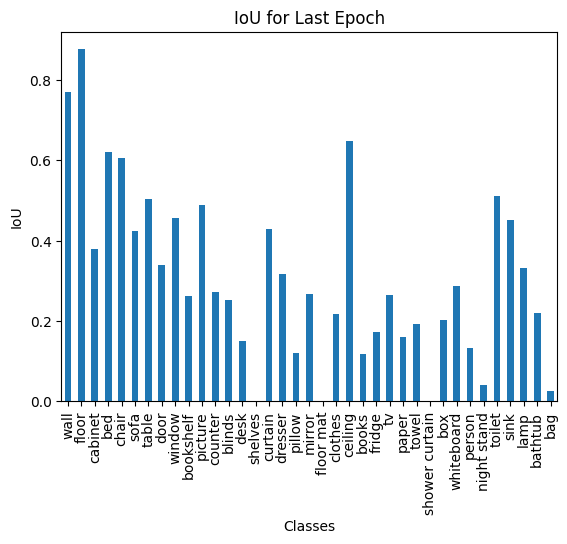

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(validation_iou_all, columns=val_dataset._class_names)
# Plot the values from the last row in a bar chart
last_row = df.iloc[-1]
last_row.plot(kind='bar', xlabel='Classes', ylabel='IoU', title='IoU for Last Epoch')
plt.show()

In [22]:
# Save metrics in csv

df.to_csv("iou_all.csv", index=False)

data = {
    'Train_Losses': train_losses,
    'Validation_Losses': validation_losses,
    'Validation_MIOU': validation_miou,
    'Validation_Accuracy': validation_accu
}

df_metrics = pd.DataFrame(data)

df_metrics.to_csv("metrics.csv", index=False)

In [44]:
# Show epoch with lowest validation loss
validation_losses.index(min(validation_losses))

0

In [24]:
# Compare different loss graphs to decide on learning rate
def show_loss(file_path, label_y=0):
    df = pd.read_csv(file_path)

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))

    plt.plot(df['Train_Losses'], label='Train Losses')
    plt.plot(df['Validation_Losses'], label='Validation Losses')

    min_value = list(df['Validation_Losses']).index(min(list(df['Validation_Losses'])))
    print(min_value)

    # Print values in last epoch
    min_loss_train = df.loc[min_value, 'Train_Losses']
    min_loss_val = df.loc[min_value, 'Validation_Losses']

    # Add a red blob at the minimum validation loss point and the values in text
    plt.scatter(min_value, min_loss_val, color='red', marker='o', label='Min Validation Loss')

    plt.text((min_value+0.3), (min_loss_train-label_y), f'{min_loss_train:.4f}', color='blue', ha='left', va='bottom',
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))

    plt.text((min_value+0.3), (min_loss_val+label_y), f'{min_loss_val:.4f}', color='orange', ha='left', va='bottom',
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))


    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Loss Over Epochs')
    plt.xticks(df.index[(df.index +1) % 10 == 0], (df.index[(df.index +1) % 10 == 0] + 1).astype(int))

    plt.legend()

    plt.savefig('loss_plot.png')

5


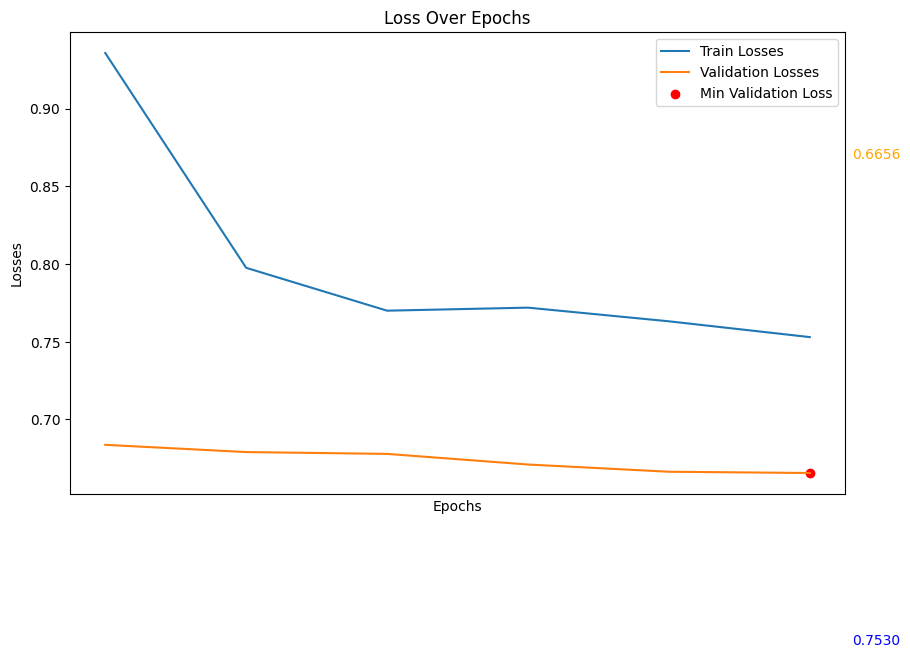

In [25]:
show_loss("metrics.csv", label_y=0.2)

In [26]:
# Check accuracy on test set
check_accuracy(test_loader, model, test_dataset, 'test', loss_fn, device=DEVICE, save_images=True)

=> Checking accuracy


Validation: 100%|██████████| 130/130 [02:55<00:00,  1.35s/batch]

Got 318560749/400817016 with acc 79.48
MUoI score: 0.37


(0.6781756233710509,
 79.4778505611149,
 0.3698735264054869,
 array([0.77744686, 0.87528438, 0.33386196, 0.65440441, 0.66377347,
        0.45414622, 0.53767398, 0.36477135, 0.52401778, 0.20313161,
        0.51278935, 0.22945708, 0.15630182, 0.14219541, 0.07533615,
        0.38948978, 0.23837166, 0.36433145, 0.28922261, 0.03044297,
        0.1369087 , 0.64916878, 0.25941092, 0.28598816, 0.35441119,
        0.22313492, 0.26294026, 0.08121244, 0.22745721, 0.27908901,
        0.31729405, 0.12072468, 0.57000102, 0.51606595, 0.37716635,
        0.34548997, 0.12686782]))